# MobileNetV2 QAT

In [1]:
# Both torch 1.9.1 and 1.13.0 should work
import torch
from torch import nn

print(torch.__version__)

1.9.1+cu102


## 1. FP32 Model Baseline

### 1.1 Create Model Architecture

In [2]:
from torch import Tensor
from typing import Callable, Any, Optional, List

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNActivation(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        activation_layer: Optional[Callable[..., nn.Module]] = None,
        dilation: int = 1,
    ) -> None:
        padding = (kernel_size - 1) // 2 * dilation
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.ReLU6
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation=dilation, groups=groups,
                      bias=False),
            norm_layer(out_planes),
            activation_layer(inplace=True)
        )
        self.out_channels = out_planes


# necessary for backwards compatibility
ConvBNReLU = ConvBNActivation

class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        **kwargs
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        **kwargs
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                # QAT Modification, pass kwargs
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer, **kwargs))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]        
        # x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.mean([2, 3])
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


### 1.2 Define dataset and data loaders

In [2]:
import torchvision
import torchvision.transforms as transforms

def prepare_data_loaders(data_path, train_batch_size, eval_batch_size):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # This ImageNet wrapper function expects the data to be one zip file                                     
    # dataset = torchvision.datasets.ImageNet(
    #     data_path, split="train", transform=transforms.Compose([
    #         transforms.RandomResizedCrop(224),
    #         transforms.RandomHorizontalFlip(),
    #         transforms.ToTensor(),
    #         normalize,
    #     ]))
    dataset = torchvision.datasets.ImageFolder(root=data_path + "/train", 
        transform=transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    # dataset_test = torchvision.datasets.ImageNet(
    #     data_path, split="val", transform=transforms.Compose([
    #         transforms.Resize(256),
    #         transforms.CenterCrop(224),
    #         transforms.ToTensor(),
    #         normalize,
    #     ]))
    dataset_test = torchvision.datasets.ImageFolder(root=data_path + "/val",
        transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]))

    train_sampler = torch.utils.data.RandomSampler(dataset)
    test_sampler = torch.utils.data.SequentialSampler(dataset_test)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=train_batch_size,
        sampler=train_sampler)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=eval_batch_size,
        sampler=test_sampler)

    return data_loader, data_loader_test

### 1.3 Define Helper Functions

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(model, criterion, data_loader, neval_batches):
    model.eval()
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    cnt = 0
    with torch.no_grad():
        for image, target in data_loader:
            output = model(image)
            loss = criterion(output, target)
            cnt += 1
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            print('.', end = '')
            top1.update(acc1[0], image.size(0))
            top5.update(acc5[0], image.size(0))
            if cnt >= neval_batches:
                 return top1, top5

    return top1, top5

### 1.4 Get Baseline Accuracy

In [4]:
eval_batch_size = 50

# Prepare test data loader
data_path = '/data/datasets/ImageNet/ilsvrc_2012'
train_dataloader, test_dataloader = prepare_data_loaders(data_path, train_batch_size=32, eval_batch_size=eval_batch_size)

In [19]:
# Load the model
fp_model = MobileNetV2()
state_dict = torch.load("data/mobilenet_v2-b0353104.pth")
fp_model.load_state_dict(state_dict)
fp_model.to('cpu')

num_eval_batches = 1000

criterion = nn.CrossEntropyLoss()
top1, top5 = evaluate(fp_model, criterion, test_dataloader, neval_batches=num_eval_batches)
print('Evaluation accuracy on %d images, %2.2f'%(num_eval_batches * eval_batch_size, top1.avg))
torch.jit.save(torch.jit.script(fp_model), "data/mobilenet_v2_scripted.pth")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## 2 PyTorch QAT

### 2.1 Define Model Architecture

- Replacing addition with nn.quantized.FloatFunctional
- Insert QuantStub and DeQuantStub at the beginning and end of the network.
- Replace ReLU6 with ReLU, otherwise PyTorch QAT has errors while do `fuse_models()`.

In [18]:
from torch.quantization import QuantStub, DeQuantStub

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes, momentum=0.1),
            # Replace with ReLU
            nn.ReLU(inplace=False)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup, momentum=0.1),
        ])
        self.conv = nn.Sequential(*layers)
        # Replace torch.add with floatfunctional
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        if self.use_res_connect:
            return self.skip_add.add(x, self.conv(x))
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0, inverted_residual_setting=None, round_nearest=8):
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
        """
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        x = self.dequant(x)
        return x

    # Fuse Conv+BN and Conv+BN+Relu modules prior to quantization
    # This operation does not change the numerics
    def fuse_model(self):
        for m in self.modules():
            if type(m) == ConvBNReLU:
                torch.quantization.fuse_modules(m, ['0', '1', '2'], inplace=True)
            if type(m) == InvertedResidual:
                for idx in range(len(m.conv)):
                    if type(m.conv[idx]) == nn.Conv2d:
                        torch.quantization.fuse_modules(m.conv, [str(idx), str(idx + 1)], inplace=True)

### 2.2 Define dataset and data loaders

- The same as FP32.

### 2.3 Define Helper Functions

- The same as FP32.

### 2.4 Training and Testing

#### 2.4.1 Load pretrained float model

In [19]:
qat_model = MobileNetV2()
state_dict = torch.load("data/mobilenet_v2-b0353104.pth")
qat_model.load_state_dict(state_dict)
print(qat_model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

#### 2.4.2 Fuse Model

In [20]:
qat_model.eval()
qat_model.fuse_model()
print(qat_model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): ConvReLU2d(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Identity()
      (2): Identity()
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): ConvReLU2d(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
            (1): ReLU()
          )
          (1): Identity()
          (2): Identity()
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (2): Identity()
      )
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): ConvReLU2d(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU()
          )
          (1): Identity()
          (2): Identity()
        )
    

#### 2.4.3 Prepare for QAT

In [21]:
# Using default qconfig
quantization_config = torch.quantization.get_default_qat_qconfig("fbgemm")
qat_model.qconfig = quantization_config
print(qat_model.qconfig)

QConfig(activation=functools.partial(<class 'torch.quantization.fake_quantize.FakeQuantize'>, observer=<class 'torch.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True), weight=functools.partial(<class 'torch.quantization.fake_quantize.FakeQuantize'>, observer=<class 'torch.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric, reduce_range=False, ch_axis=0))


In [22]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

qat_model.train()
qat_model.to(device)
torch.quantization.prepare_qat(qat_model, inplace=True)
print(qat_model)

Using cuda device
MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): ConvReLU2d(
        3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (weight_fake_quant): FakeQuantize(
          fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric, ch_axis=0, scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0')
          (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([], device='cuda:0'), max_val=tensor([], device='cuda:0'))
        )
        (activation_post_process): FakeQuantize(
          fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.], device='

#### 2.4.4 Training and Testing

- Training can be done on GPU/CUDA, testing has to be done on CPU.

In [23]:
import time

def train_one_epoch(model, criterion, optimizer, data_loader, device, ntrain_batches):
    model.train()
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    avgloss = AverageMeter('Loss', '1.5f')

    cnt = 0
    for image, target in data_loader:
        start_time = time.time()
        print('.', end = '')
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0], image.size(0))
        top5.update(acc5[0], image.size(0))
        avgloss.update(loss, image.size(0))
        if cnt >= ntrain_batches:
            print('Loss', avgloss.avg)

            print('Training: * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
                  .format(top1=top1, top5=top5))
            return

    print('Full imagenet train set:  * Acc@1 {top1.global_avg:.3f} Acc@5 {top5.global_avg:.3f}'
          .format(top1=top1, top5=top5))
    return

In [25]:
num_train_batches = 20
num_eval_batches = 10
eval_batch_size = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(qat_model.parameters(), lr = 0.0001)

# QAT takes time and one needs to train over a few epochs.
# Train and check accuracy after each epoch
for nepoch in range(8):
    qat_model.to(device)
    train_one_epoch(qat_model, criterion, optimizer, train_dataloader, device, num_train_batches)
    if nepoch > 3:
        # Freeze quantizer parameters
        qat_model.apply(torch.quantization.disable_observer)
    if nepoch > 2:
        # Freeze batch norm mean and variance estimates
        qat_model.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

    # Check the accuracy after each epoch
    qat_model.to('cpu')
    quantized_model = torch.quantization.convert(qat_model.eval(), inplace=False)
    quantized_model.eval()    
    top1, top5 = evaluate(quantized_model, criterion, test_dataloader, neval_batches=num_eval_batches)
    print('Epoch %d :Evaluation accuracy on %d images, %2.2f'%(nepoch, num_eval_batches * eval_batch_size, top1.avg))

....................Loss tensor(1.7670, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 59.688 Acc@5 79.844
..........Epoch 0 :Evaluation accuracy on 500 images, 75.80
....................Loss tensor(1.4418, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 66.406 Acc@5 84.219
..........Epoch 1 :Evaluation accuracy on 500 images, 78.00
....................Loss tensor(1.5081, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 62.812 Acc@5 84.375
..........Epoch 2 :Evaluation accuracy on 500 images, 77.40
....................Loss tensor(1.5501, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 64.219 Acc@5 84.062
..........Epoch 3 :Evaluation accuracy on 500 images, 74.80
....................Loss tensor(1.4629, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 65.000 Acc@5 85.625
..........Epoch 4 :Evaluation accuracy on 500 images, 74.80
....................Loss tensor(1.3761, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 65.938

## 3 BST QAT

### 3.0 Make sure bstnnx_training package is in the system python path

In [26]:
# Make sure bstnnx_training is in the system Python path
import sys
import os

sys.path.append("/home/hongbing/Projects/bst-study/bstnnx_training")

import bstnnx_training

print(bstnnx_training.__version__)

1.4.3.2


### 3.1 Define Model Architecture

- Comparing to PyTorch QAT, we only need replacing addition with torch.add()

In [35]:
from torch.quantization import QuantStub, DeQuantStub
from bstnnx_training.PyTorch.QAT import modules as bst

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes, momentum=0.1),
            # Replace with ReLU
            nn.ReLU(inplace=False)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup, momentum=0.1),
        ])
        self.conv = nn.Sequential(*layers)
        # Replace torch.add with floatfunctional
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        if self.use_res_connect:
            return torch.add(x, self.conv(x))
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0, inverted_residual_setting=None, round_nearest=8):
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
        """
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        x = self.dequant(x)
        return x

    # Fuse Conv+BN and Conv+BN+Relu modules prior to quantization
    # This operation does not change the numerics
    def fuse_model(self):
        for m in self.modules():
            if type(m) == ConvBNReLU:
                torch.quantization.fuse_modules(m, ['0', '1', '2'], inplace=True)
            if type(m) == InvertedResidual:
                for idx in range(len(m.conv)):
                    if type(m.conv[idx]) == nn.Conv2d:
                        torch.quantization.fuse_modules(m.conv, [str(idx), str(idx + 1)], inplace=True)

### 3.2 Define dataset and data loaders

- The same as FP32 and PyTorch QAT

### 3.3 Define Helper Functions

- The Same as FP32 and PyTorch QAT

### 3.4 Training and Testing

#### 3.4.1 Load pretrained float model

- The same as PyTorch QAT

In [36]:
bst_model = MobileNetV2()
state_dict = torch.load("data/mobilenet_v2-b0353104.pth")
bst_model.load_state_dict(state_dict)
# print(qat_model)

<All keys matched successfully>

#### 3.4.2 Fuse Model

- The same as PyTorch QAT

In [37]:
bst_model.eval()
bst_model.fuse_model()
# print(bst_model)

#### 3.4.3 Prepare for BST QAT

In [39]:
# switch the quantization framework
import bstnnx_training.PyTorch.QAT.core as quantizer

bst_activation_quant = quantizer.FakeQuantize.with_args(observer=quantizer.MinMaxObserver.with_args(dtype=torch.qint8), 
            quant_min=-128, 
            quant_max=127, 
            dtype=torch.qint8, 
            qscheme=torch.per_tensor_affine, 
            reduce_range=False)
bst_weight_quant = quantizer.FakeQuantize.with_args(observer=quantizer.MinMaxObserver.with_args(dtype=torch.qint8), 
            quant_min=-128, 
            quant_max=127, 
            dtype=torch.qint8, 
            qscheme=torch.per_tensor_affine, 
            reduce_range=False)
        
# 1) [bst_alignment] get b0 pre-bind qconfig adjusting Conv's activation quant scheme
sample_data = torch.randn(1, 3, 224, 224, requires_grad=True)
pre_bind_qconfig = quantizer.pre_bind(bst_model, input_tensor=sample_data.to('cpu'))
        
# 2) assign qconfig to model
bst_model.qconfig = quantizer.QConfig(activation=bst_activation_quant, 
                                        weight=bst_weight_quant,
                                        qconfig_dict=pre_bind_qconfig)
        
# 3) prepare qat model using qconfig settings
bst_model.train()
prepared_model = quantizer.prepare_qat(bst_model, inplace=False)  
        
# 4) [bst_alignment] link model observers
prepared_model = quantizer.link_modules(prepared_model, auto_detect=True, input_tensor=sample_data.to('cpu'), inplace=False)
    
prepared_model.eval()

/home/hongbing/Projects/bst-study/bstnnx_training/bstnnx_training/PyTorch/QAT/core/observer/bst_min_max_observer.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_v = torch.tensor(max(abs(self.min_val), abs(self.max_val)), device=device)


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): ConvReLU2d(
        3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (weight_fake_quant): FakeQuantize(
          fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0])
          (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
        )
        (activation_post_process): FakeQuantize(
          fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0])
          (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
        )
      )
      (1): Identity()
      (2): Identity()
    )
    (1): InvertedResidual(
 

#### 2.4.4 Training and Testing

In [42]:
model = prepared_model

num_train_batches = 20
num_eval_batches = 10
eval_batch_size = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)

# QAT takes time and one needs to train over a few epochs.
# Train and check accuracy after each epoch
for nepoch in range(8):
    model.to(device)
    train_one_epoch(model, criterion, optimizer, train_dataloader, device, num_train_batches)
    if nepoch > 3:
        # Freeze quantizer parameters
        model.apply(torch.quantization.disable_observer)
    if nepoch > 2:
        # Freeze batch norm mean and variance estimates
        model.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

    # Check the accuracy after each epoch
    model.to('cpu')
    quantized_model = torch.quantization.convert(model.eval(), inplace=False)
    quantized_model.eval()    
    top1, top5 = evaluate(model, criterion, test_dataloader, neval_batches=num_eval_batches)
    print('\nEpoch %d :Evaluation accuracy on %d images, %2.2f'%(nepoch, num_eval_batches * eval_batch_size, top1.avg))

.

/home/hongbing/Projects/bst-study/bstnnx_training/bstnnx_training/PyTorch/QAT/core/observer/bst_min_max_observer.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_v = torch.tensor(max(abs(self.min_val), abs(self.max_val)), device=device)


...................Loss tensor(1.9692, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 57.969 Acc@5 78.906


/home/hongbing/Projects/bst-study/bstnnx_training/bstnnx_training/PyTorch/QAT/core/observer/bst_min_max_observer.py:20: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


..........Epoch 0 :Evaluation accuracy on 500 images, 73.60
....................Loss tensor(1.8329, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 57.812 Acc@5 81.406
..........Epoch 1 :Evaluation accuracy on 500 images, 69.80
....................Loss tensor(1.9330, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 58.750 Acc@5 77.969
..........Epoch 2 :Evaluation accuracy on 500 images, 72.00
....................Loss tensor(1.7490, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 58.906 Acc@5 82.031
..........Epoch 3 :Evaluation accuracy on 500 images, 72.20
....................Loss tensor(1.8002, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 57.500 Acc@5 80.938
..........Epoch 4 :Evaluation accuracy on 500 images, 71.60
....................Loss tensor(1.7291, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 59.531 Acc@5 80.781
..........Epoch 5 :Evaluation accuracy on 500 images, 71.00
....................Loss tensor(1.6262, devic

### 3.5 Export float ONNX model and JSON

In [44]:
sample_data = torch.randn(1, 3, 224, 224, requires_grad=False)

stage_dict={}
stage_dict['simplify_onnx'] = True
onnx_model_path, quant_param_json_path = quantizer.export_onnx(prepared_model, 
                                                               sample_data, 
                                                               stage_dict=stage_dict, 
                                                               result_dir='./data')

Conv_12's activation is not recorded in tensor qparams


KeyError: '987'

### 4. BST Quantize Model

In [23]:
fp32_model = mobilenet_v2(pretrained=False, progress=True, use_bstnn=True).to(device)
loaded_dict_enc = torch.load(fp32_mobilenet_v2_pt_path, map_location=device)
fp32_model.load_state_dict(loaded_dict_enc)

<All keys matched successfully>

In [24]:
float_loss, float_acc = test(fp32_model, device, test_loader)

In [25]:
print(f"Loss: {float_loss} | Accuracy: {float_acc}")

Loss: 1.0152559280395508 | Accuracy: 100.0


In [26]:
fp32_model = mobilenet_v2(pretrained=False, progress=True, use_bstnn=True).to(device)
loaded_dict_enc = torch.load(fp32_mobilenet_v2_pt_path, map_location=device)
fp32_model.load_state_dict(loaded_dict_enc)

# define test data used for fusing model
random_data = np.random.rand(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH).astype("float32")
sample_data = torch.from_numpy(random_data).to(device)

# use CPU on input_tensor as our backend for parsing GraphTopology forced model to be on CPU
fp32_model.eval()
fused_model = quantizer.fuse_modules(fp32_model, auto_detect=True, input_tensor=sample_data.cpu())
prepared_model = quantize_model(fused_model, device, backend="bst", sample_data=sample_data)

/home/zihaozhao/.local/lib/python3.7/site-packages/torch/nn/modules/module.py:1051: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return forward_call(*input, **kwargs)


In [27]:
prepared_model

QuantizableMobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(
        3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (weight_fake_quant): FakeQuantize(
          fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0])
          (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
        )
        (activation_post_process): FakeQuantize(
          fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0])
          (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
        )
      )
      (1): Identity()
      (2): ReLU()
    )
    (1): Quantizabl

### 5. Quant-aware-training

In [28]:
quant_aware_training(prepared_model, device, train_loader, sample_data)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10


### Extra step:  Export float ONNX model and Json and optimize them with hardware constraints

In [29]:
rand_in = np.random.rand(1, 1, 3, IMAGE_HEIGHT, IMAGE_WIDTH).astype("float32")
sample_in = tuple(torch.from_numpy(x) for x in rand_in)
stage_dict={}
stage_dict['simplify_onnx'] = True
onnx_model_path, quant_param_json_path = quantizer.export_onnx(prepared_model, 
                                                               sample_in, 
                                                               stage_dict=stage_dict, 
                                                               result_dir=tmp_dir)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
100%|██████████| 102/102 [00:00<00:00, 257567.13it/s]


##  Model conversion flow

In [30]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [31]:
%%writetemplate $tmp_dir/test_e2e_qat.yaml

data_reader_method: random_data_reader
model_name: qat_frozen_model
model_path: {onnx_model_path}
batch_size: 1
size_limit: 10
non_image_input: True
enable_in_scale: True
orig_model_format: onnx
device_engine: 'A1000B0'
stage:
  - stage_name: pre_processing_stage
    priority: 100
  - stage_name: graph_optimization_stage
    run_built_in_optimization: True
    optimization_passes:
      - convert_gemm
      - convert_max_pool_to_dsp
      - convert_slice
      - convert_eltwise_add
      - convert_eltwise_mul
      - convert_global_avgpool
      - fuse_activation
      - convert_relu
      - fuse_conv_add
      - convert_to_skip_node
      - convert_resize_to_bst_resize
    optimization_parameters:
        fuse_conv_add:
            quant_params_json_path: {quant_param_json_path}
    priority: 200
  - stage_name: quantization_stage
    quantization_method: bst_standard_quantization_flow
    quant_params_json_path: {quant_param_json_path}
    priority: 300  
  - stage_name: graph_partition_stage
    priority: 400
  - stage_name: section_binding_stage
    priority: 500
  - stage_name: code_generation_stage
    priority: 600
  - stage_name: code_compilation_stage
    priority: 700
  - stage_name: run_emulation_stage
    profiling_mode: 2
    priority: 800
  - stage_name: partition_evaluation_stage
    priority: 900
  - stage_name: run_emulation_stage
    profiling_mode: 0
    priority: 1000

In [32]:
CONFIG_FILE_PATH = os.path.join(tmp_dir, "test_e2e_qat.yaml")
RESULT_DIR = output_dir

[bstnnx.frontend.stage_flow_control_main][INFO   ]  bstnnx.__version__ = 4.0.8 (stage_flow_control_main.py:246)
[bstnnx.frontend.stage_flow_control_main][INFO   ]  bstnnx.version.git_version = 818a5f312cac177fdcd1ffdbf0e80730ee578bf7 (stage_flow_control_main.py:247)
[bstnnx.engine.A1000B0][INFO   ]  Running on A1000B0 (stage_flow_control_main.py:253)
[bstnnx.utils.base   ][INFO   ]  Execute PreProcessingStage:bstnnx_run (stage_flow_control_main.py:305)
[bstnnx.utils.base   ][INFO   ]  successfully create stage_result_dir /bsnn/users/zihaozhao/QAT/alan/results/job0/100_PreProcessingStage (stage_flow_control_main.py:305)
[bstnnx.utils.timer  ][INFO   ]  Start profiling function PreProcessingStage.run. (stage_flow_control_main.py:306)
[bstnnx.frontend.pre_processing_stage][INFO   ]  Execute PreProcessingStage:100:run (pre_processing_stage.py:437)
[bstnnx.frontend.pre_processing_stage][INFO   ]  The model is valid! (pre_processing_stage.py:566)


main_cf._data['device_engine']=A1000B0


[bstnnx.utils.timer  ][INFO   ]  Function PreProcessingStage.run took 0.3940918445587158 seconds to complete. (stage_flow_control_main.py:306)
[bstnnx.frontend.pre_processing_stage][INFO   ]  Execute PreProcessingStage:100:done (pre_processing_stage.py:694)
[bstnnx.utils.base   ][INFO   ]  Execute GraphOptimizationStage:bstnnx_run (stage_flow_control_main.py:305)
[bstnnx.utils.base   ][INFO   ]  successfully create stage_result_dir /bsnn/users/zihaozhao/QAT/alan/results/job0/200_GraphOptimizationStage (stage_flow_control_main.py:305)
[bstnnx.utils.timer  ][INFO   ]  Start profiling function GraphOptimizationStage.run. (stage_flow_control_main.py:306)
[bstnnx.frontend.graph_optimization_stage][INFO   ]  Execute GraphOptimizationStage:200:run (graph_optimization_stage.py:71)
[bstnnx.bst_optimizer.split_group_conv][INFO   ]  Output_channel_unit is 16 (graph_optimization_stage.py:237)
[bstnnx.bst_optimizer.split_group_conv][INFO   ]  Split_method is evenly (graph_optimization_stage.py:237)

[bstnnx.utils.quantization_utils][INFO   ]  conv_move_add: Add_129_conv_move_add (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  there is no relu node (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  add_output_name: Add_129_conv_move_add:0 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  conv node name: Conv_211 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  sub node names: [] (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  add node name: Add_218 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  relu node name: None (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  output_channels: 32 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  conv_ch_num: 32 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  num_add: 32 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  

[bstnnx.utils.quantization_utils][INFO   ]  num_insert: 0 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  new_conv_node_output: Add_451_preshift_quant_out:0 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  new_perm_node_output: 1378 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  conv_move_add: Add_451_conv_move_add (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  there is no relu node (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  add_output_name: Add_451_conv_move_add:0 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  conv node name: Conv_533 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  sub node names: [] (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  add node name: Add_540 (quantization_stage.py:113)
[bstnnx.utils.quantization_utils][INFO   ]  relu node name: None (quantization_stage.py:113)


[bstnnx.utils.base   ][INFO   ]  successfully create stage_result_dir /bsnn/users/zihaozhao/QAT/alan/results/job0/400_GraphPartitionStage (stage_flow_control_main.py:305)
[bstnnx.utils.timer  ][INFO   ]  Start profiling function GraphPartitionStage.run. (stage_flow_control_main.py:306)
[bstnnx.frontend.graph_partition_stage][INFO   ]  Execute GraphPartitionStage:400:run (graph_partition_stage.py:60)
[bstnnx.frontend.graph_partition_stage][INFO   ]  Use partition_greedy method. (graph_partition_stage.py:115)
[bstnnx.partition.graph][INFO   ]  Boundaries indxes = [51, 52, 53, 54, 55, 56] (graph_partition_stage.py:119)
[bstnnx.partition.graph][INFO   ]  Total boundaries number = 6 (graph_partition_stage.py:119)
[bstnnx.partition.section_optimizers.separate_fused_conv_add][INFO   ]  Node Fused_Conv_Add_279 is a Fused_Conv_Add node, separating it into a Conv and a Fused_Add or a Fused_Conv and an Add (graph_partition_stage.py:119)
[bstnnx.partition.section_optimizers.separate_fused_conv_add

inputs={'0'}, outputs={'1761'}
inputs={'1761'}, outputs={'1764'}
inputs={'1764'}, outputs={'1783'}


[bstnnx.frontend.section_binding_stage][INFO   ]  BTMD/BTMW debug information: 0_2: BTMD(802816), BTMW(1701248) (section_binding_stage.py:126)
[bstnnx.frontend.section_binding_stage][INFO   ]  BTMD/BTMW debug information: 3_3: BTMD(65536), BTMW(0) (section_binding_stage.py:126)
[bstnnx.frontend.section_binding_stage][INFO   ]  BTMD/BTMW debug information: 4_4: BTMD(4096), BTMW(1294272) (section_binding_stage.py:126)
[bstnnx.utils.timer  ][INFO   ]  Function SectionBindingStage.run took 71.67428779602051 seconds to complete. (stage_flow_control_main.py:306)
[bstnnx.frontend.section_binding_stage][INFO   ]  Execute SectionBindingStage:500:done (section_binding_stage.py:154)
[bstnnx.utils.base   ][INFO   ]  Execute CodeGenerationStage:bstnnx_run (stage_flow_control_main.py:305)
[bstnnx.utils.base   ][INFO   ]  successfully create stage_result_dir /bsnn/users/zihaozhao/QAT/alan/results/job0/600_CodeGenerationStage (stage_flow_control_main.py:305)
[bstnnx.utils.timer  ][INFO   ]  Start prof

successfully run through emulator and get consistent with result with CPUBackend !!  (/bsnn/users/zihaozhao/QAT/alan/results/job0/800_RunEmulationStage/sec_3_3)


[bstnnx.tools        ][INFO   ]  cmd = bash ./run_simulation.sh (__init__.py:72)


successfully run through emulator and get consistent with result with CPUBackend !!  (/bsnn/users/zihaozhao/QAT/alan/results/job0/800_RunEmulationStage/sec_0_2)
successfully run through emulator and get consistent with result with CPUBackend !!  (/bsnn/users/zihaozhao/QAT/alan/results/job0/800_RunEmulationStage/sec_4_4)


[bstnnx.utils.timer  ][INFO   ]  Function RunEmulationStage.run took 19.38118886947632 seconds to complete. (stage_flow_control_main.py:306)
[bstnnx.frontend.run_emulation_stage][INFO   ]  Execute RunEmulationStage:800:done (run_emulation_stage.py:735)
[bstnnx.utils.base   ][INFO   ]  Execute PartitionEvaluationStage:bstnnx_run (stage_flow_control_main.py:305)
[bstnnx.utils.base   ][INFO   ]  successfully create stage_result_dir /bsnn/users/zihaozhao/QAT/alan/results/job0/900_PartitionEvaluationStage (stage_flow_control_main.py:305)
[bstnnx.utils.timer  ][INFO   ]  Start profiling function PartitionEvaluationStage.run. (stage_flow_control_main.py:306)
[bstnnx.frontend.partition_evaluation_stage][INFO   ]  Execute PartitionEvaluationStage:900:run (partition_evaluation_stage.py:150)
[bstnnx.utils.timer  ][INFO   ]  Function PartitionEvaluationStage.run took 6.126962900161743 seconds to complete. (stage_flow_control_main.py:306)
[bstnnx.frontend.partition_evaluation_stage][INFO   ]  Execu

successfully run through emulator and get consistent with result with CPUBackend !!  (/bsnn/users/zihaozhao/QAT/alan/results/job0/1000_RunEmulationStage/sec_3_3)


[bstnnx.tools        ][INFO   ]  cmd = bash ./run_simulation.sh (__init__.py:72)


successfully run through emulator and get consistent with result with CPUBackend !!  (/bsnn/users/zihaozhao/QAT/alan/results/job0/1000_RunEmulationStage/sec_4_4)
successfully run through emulator and get consistent with result with CPUBackend !!  (/bsnn/users/zihaozhao/QAT/alan/results/job0/1000_RunEmulationStage/sec_0_2)


[bstnnx.utils.timer  ][INFO   ]  Function RunEmulationStage.run took 39.828617334365845 seconds to complete. (stage_flow_control_main.py:306)
[bstnnx.frontend.run_emulation_stage][INFO   ]  Execute RunEmulationStage:1000:done (run_emulation_stage.py:735)


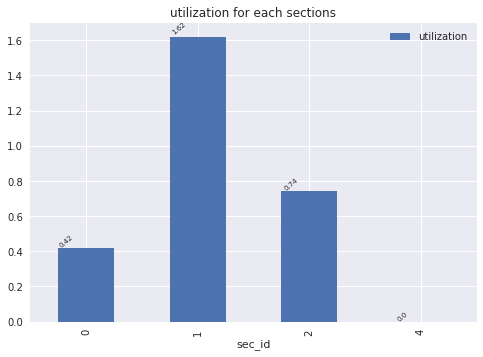

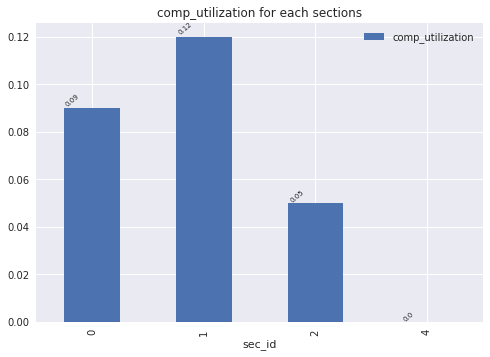

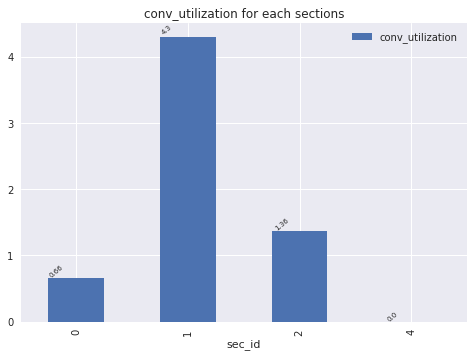

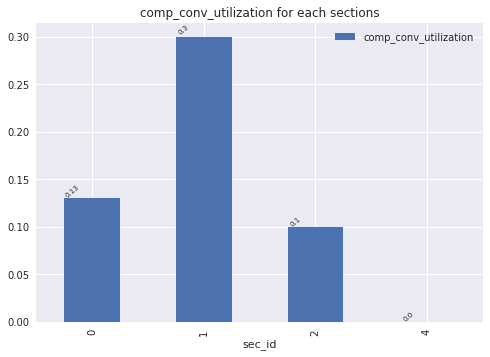

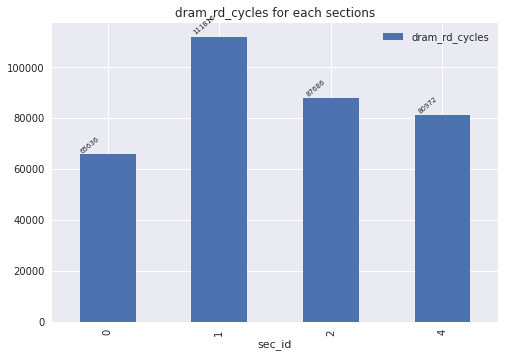

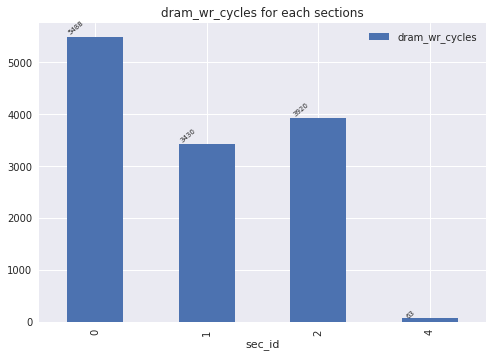

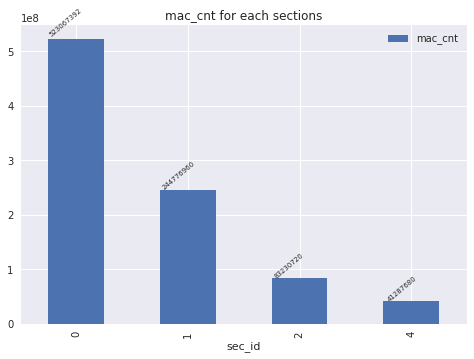

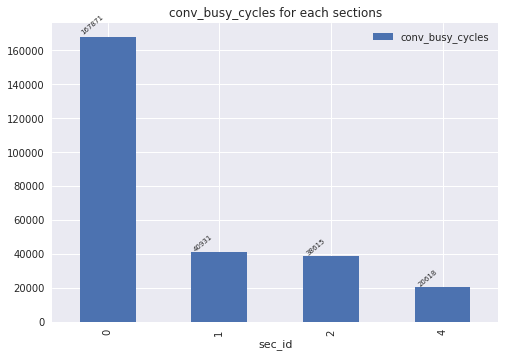

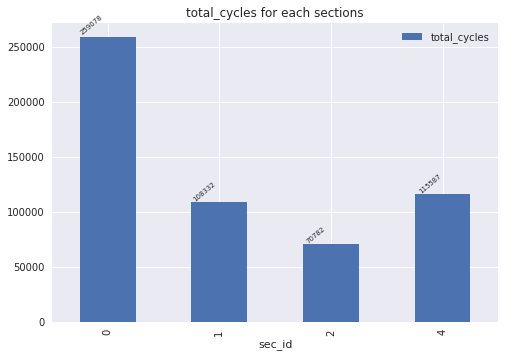

In [33]:
import bstnnx.frontend.stage_flow_control_main
RESULT_DIR = output_dir
extra_option = {
    "logging_level": "INFO",
    "priority_range": "100-1000,1200",
    "build_type": "html",
    "BSTNNX_NET_FW_DIR": "/bsnn/work/bstnnx_release/third_party/Net-FW-xos-v0-edp-gemm"
}

bstnnx.frontend.stage_flow_control_main.bstnnx_run(config=CONFIG_FILE_PATH, \
                                                      result_dir=RESULT_DIR, \
                                                      extra=extra_option)

# Sanity check with reference Model

In [34]:
bst_reference_model_path = os.path.join(output_dir, "300_QuantizationStage/quant_model.onnx")

In [39]:
device = 'cpu'
custom_bst_op_path = bstnnx.backend.custom_op.get_custom_op_lib_path()
onnx_rep = runtime_helper.OnnxRep(bst_reference_model_path, custom_op_lib=custom_bst_op_path)
bst_refernce_loss, bst_reference_acc  = test(onnx_rep, device, test_loader)
print(bst_refernce_loss, bst_reference_acc)

0.3476797342300415 100.0


```{.python .input}
print(f"Float model - Loss: {float_loss} | Accuracy: {float_acc}")
print(f"Torch QAT model - Loss: {torch_qat_loss} | Accuracy: {torch_qat_acc}")
print(f"BST Reference model - Loss: {bst_refernce_loss} | Accuracy: {bst_reference_acc}")
```